In [ ]:
# Digit Recognizer (Supervised Learning: Classification)
# For this project, we will be using a Convolutional Neural Network
# to figure out the digits in the MNIST dataset images

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader

In [ ]:
# Global Variables
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

seed_num = 1
torch.manual_seed(seed_num)
torch.backends.cudnn.enabled = False

In [ ]:
class CustomTrainCSVDataset(DataLoader):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.data.iloc[idx, 0]
        sample = self.data.iloc[idx, 1:].values.astype(np.float32)

        sample = sample.reshape(28, 28)  # Assuming the data represents 28x28 images

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
class CustomTestCSVDataset(DataLoader):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data.iloc[idx, :].values.astype(np.float32)

        sample = sample.reshape(28, 28)  # Assuming the data represents 28x28 images

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
#Get training data and test data

# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load training data from CSV file
train_dataset = CustomTrainCSVDataset('sample_data/train.csv', transform=transform)

# Split the data into training and verification data
train_set, ver_set = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

# Create DataLoader for training data
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)

verify_loader = DataLoader(ver_set, batch_size=batch_size_train, shuffle=True)

# Load test data from CSV file
test_dataset = CustomTestCSVDataset('sample_data/test.csv', transform=transform)

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [ ]:
#Create MLP Model using Pytorch
class DigitRecognizerModel(nn.Module):
    def __init__(self):
        super(DigitRecognizerModel, self).__init__()

        # Create the Convolutional layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Create the dropout layer to prevent overfitting
        self.conv2_drop = nn.Dropout2d()  # 50% chance of an input being zeroed out to prevent overfitting
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    # Forward Pass Function to Predict Ouput
    def forward(self, x):
        # first convolutional layer
        x = self.conv1(x)
        x = F.max_pool2d(x, 2) # Applies 2D max pooling operation to reduce the spatial dimensions of the tensor by a factor of 2 along both dimensions
        x = F.relu(x) # Applies the rectified linear unit (ReLU) activation function element-wise to the tensor.

        # second convolutional layer
        x = self.conv2(x)
        x = self.conv2_drop(x) # Applies dropout to the output of the second convolutional layer.
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = F.dropout(x, training=self.training) # dropouut layer that applies only when training

        x = x.view(-1, 320) # Reshapes the tensor into 1D for use in dense layers

        # First fully connected layer
        x = self.fc1(x)
        x = F.relu(x)

        # Second fully connected layer
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) # Converts the raw output scores into log probabilities by applying the log_softmax function to the class dimension  of the tensor
        return x

In [ ]:
network = DigitRecognizerModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
predictions = []

In [ ]:
# Train the model
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network.state_dict(), 'sample_data/model.pth')
        torch.save(optimizer.state_dict(), 'sample_data/optimizer.pth')

In [ ]:
# Test the Model
def verify():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in verify_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(verify_loader.dataset)
    test_losses.append(test_loss)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(verify_loader.dataset), 100. * correct / len(verify_loader.dataset)))

In [ ]:
# Use the model to predict the test data
def test():
    network.eval() # Sets network to evaluation mode mode
    all_predictions = []
    with torch.no_grad(): # Disable gradient calculations to speed up predictions
        for data in test_loader:
            output = network(data)
            pred = output.argmax(dim=1)  # Get the index of the max log-probability
            all_predictions.extend(pred.cpu().numpy())  # Convert predictions to numpy array and extend list
    return all_predictions

In [ ]:
# Plot the distribution of predictions
def plot_prediction_distribution(predictions):
    plt.figure(figsize=(8, 5))
    plt.hist(predictions, bins=range(11), alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predictions')
    plt.xticks(range(10))
    plt.grid(axis='y', alpha=0.75)
    plt.show()


Validation set: Average loss: 0.1098, Accuracy: 8141/8400 (97%)

Train Epoch: 1 [0/33600 (0%)]	Loss: 0.124878
Train Epoch: 1 [640/33600 (2%)]	Loss: 0.259657
Train Epoch: 1 [1280/33600 (4%)]	Loss: 0.367980
Train Epoch: 1 [1920/33600 (6%)]	Loss: 0.418668
Train Epoch: 1 [2560/33600 (8%)]	Loss: 0.418923
Train Epoch: 1 [3200/33600 (10%)]	Loss: 0.425082
Train Epoch: 1 [3840/33600 (11%)]	Loss: 0.278961
Train Epoch: 1 [4480/33600 (13%)]	Loss: 0.211001
Train Epoch: 1 [5120/33600 (15%)]	Loss: 0.402049
Train Epoch: 1 [5760/33600 (17%)]	Loss: 0.268425
Train Epoch: 1 [6400/33600 (19%)]	Loss: 0.138565
Train Epoch: 1 [7040/33600 (21%)]	Loss: 0.228877
Train Epoch: 1 [7680/33600 (23%)]	Loss: 0.407394
Train Epoch: 1 [8320/33600 (25%)]	Loss: 0.161468
Train Epoch: 1 [8960/33600 (27%)]	Loss: 0.263698
Train Epoch: 1 [9600/33600 (29%)]	Loss: 0.262500
Train Epoch: 1 [10240/33600 (30%)]	Loss: 0.173329
Train Epoch: 1 [10880/33600 (32%)]	Loss: 0.460889
Train Epoch: 1 [11520/33600 (34%)]	Loss: 0.265379
Train Epo

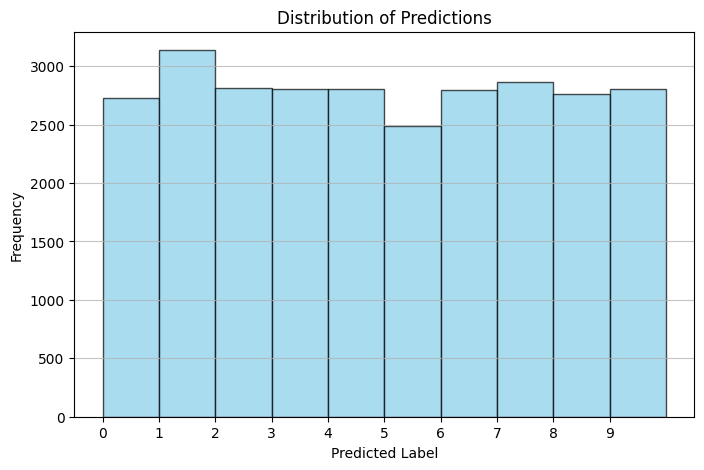

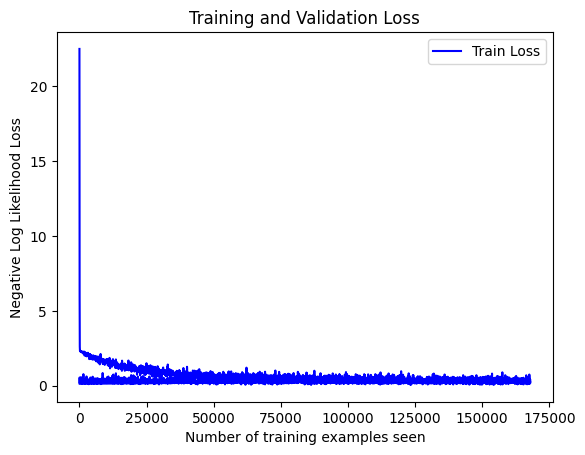

In [ ]:
verify() # Test cnn to see how it does with no training
for epoch in range(1, n_epochs + 1):
    train(epoch)
    verify()

# use the model to predict the test data
predictions = test()

# Load test data from CSV file
test_dataset = CustomTestCSVDataset('sample_data/test.csv', transform=transform)
images = [test_dataset[i].squeeze().numpy() for i in range(10)]

# Call the function to plot the distribution of predictions
plot_prediction_distribution(predictions)

# Create a DataFrame with the predictions
submission_df = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Define the figure for plotting
fig, ax = plt.subplots()

# Plot the training loss
ax.plot(train_counter, train_losses, color='blue', label='Train Loss')


# Add labels and title
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Negative Log Likelihood Loss')
ax.set_title('Training and Validation Loss')
ax.legend()

# Show the plot
plt.show()